### Imports

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from numpy import argmax
from scipy import constants
import random

import os
import sys
import re
import pdb
import glob

import suftware

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Lambda, Concatenate
from keras.optimizers import Adam
from keras import metrics
from keras import regularizers
from keras import callbacks
import keras.backend as K

import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
plt.ion()

Using TensorFlow backend.


 Load the energy matrices from Kinney et al. 2010. These will be used later for comparison

In [2]:
crp_df = pd.read_csv('data/energy_matrices/crp_tau_final_all.26.txt', sep = "\t", usecols = range(1,5))
rnap_df = pd.read_csv('data/energy_matrices/rnap_tau_final_all.41.txt', sep = "\t", usecols = range(1,5))

# Convert the dataframe to numpy array for downstream processing
crp_array = pd.DataFrame.to_numpy(crp_df)
rnap_array = pd.DataFrame.to_numpy(rnap_df)

Helper function for one-hot encoding

In [3]:
# Fit a label encoder and a onehot encoder
bases = ["A","C","G","T"]
label_encoder = LabelEncoder()
label_encoder.fit(bases)
tmp = label_encoder.transform(bases)
tmp = tmp.reshape(len(tmp), 1)
onehot_encoder = OneHotEncoder(sparse = False)
onehot_encoder.fit(tmp)

# Encode sequence into onehot
def onehot_sequence(sequence, lab_encoder = label_encoder, one_encoder = onehot_encoder):
    """Sequence as a string"""
    tmp = lab_encoder.transform(list(sequence))
    tmp = tmp.reshape(len(tmp),1)
    tmp = one_encoder.transform(tmp)
    return tmp

### Load Input Data

In [6]:
input_data_full_wt = pd.read_csv('data/full-wt/data.txt',delim_whitespace=True)

Put data into lists and feed them to sklearn's train_test_split method

In [7]:
sequences = []
bin_number = []

for _ in range(len(input_data_full_wt)):
    sequences.append(input_data_full_wt['seq'][_])
    bin_number.append(list(input_data_full_wt.iloc[_,1:len(input_data_full_wt.columns)].values))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(sequences, bin_number, test_size=0.2)

In [12]:
######
## Define custom function for keras
######

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


One-hot encode the sequences at the location of CRP and RNAP binding sites

In [13]:
input_seqs_ohe = []
for _ in range(len(X_train)):
    input_seqs_ohe.append(onehot_sequence(X_train[_][1:27]+X_train[_][34:75]))
    
test_seqs_ohe = []    
for _ in range(len(X_test)):
    test_seqs_ohe.append(onehot_sequence(X_test[_][1:27]+X_test[_][34:75]))

Shapes of the training and test sets:

In [14]:
print(np.shape(input_seqs_ohe))
print(np.shape(test_seqs_ohe))

(40414, 67, 4)
(10104, 67, 4)


In [18]:
from keras.layers import multiply

class CustomConnected(Dense):

    def __init__(self,units,connections, output_dim,**kwargs):
        
        self.output_dim = output_dim
        #this is matrix of connections. I.e., this should be [0,0,trainable,trainable]
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    def call(self, inputs):
        #print(self.connections)
        
        kernel_times_connections = multiply([self.kernel, self.connections])
        #output = K.dot(inputs, self.kernel * self.connections)
        
        # for implementing custom constraint, print out kernel. Set last two elements equal to each other.
        output = K.dot(inputs,kernel_times_connections)
        
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    

## Model definitions

In [22]:
number_input_layer_nodes = len(input_seqs_ohe[0])*4 +1   
inputTensor = Input((number_input_layer_nodes,),name='Sequence')

# define two groups which represent binding sites for the two proteins crp and rnap
group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)
group3 = Lambda(lambda x: x[:,268:269], output_shape=((1,)))(inputTensor)


# From input to first hidden layer. The groups are connected to two nodes
# node group1 represents energy of crp and group2 represents rnap energy.

# rename group1 to crp pwm

group1 = Dense(1,use_bias=True,name='CRP_pwm')(group1)
group2 = Dense(1,use_bias=True,name='RNAP_pwm')(group2)
group3 = Dense(1,use_bias=False,name='one-feature')(group3)

# the groups from the previous layer have to be concatenated:
concatenateLayer = Concatenate()([group1,group2,group3])

# gammaInput = Input(shape=(1,),name='gamma_Input')   # i.e. weights going into softmax: [0,0,0,1]

softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=False,name='softmax_layer')(concatenateLayer)

tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
intermediateTensor = Dense(10,activation='softmax', trainable=True, use_bias=False,name='softmax_layer_intermediate')(tauTensor)
outputTensor = Dense(np.shape(y_train[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(intermediateTensor)


#create the model:
model = Model(inputTensor,outputTensor)

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence (InputLayer)           (None, 269)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 104)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 164)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           Sequence[0][0]                   
__________________________________________________________________________________________________
CRP_pwm (D

In [25]:
model.layers

Model layer 6 represents the value of $\Delta G_I$, check its value before training

In [27]:
print(model.layers[6].get_weights())

[array([[-0.6022438]], dtype=float32)]


### Set weights for $\tau$ layer...
... so that only the two microstates (with bound RNAP) contribute to transcription

In [28]:
tau_layer_weights = model.layers[9].get_weights()[0].copy()
tau_layer_weights.shape

(4, 1)

In [29]:
tau_layer_initial_weights = np.array([0,0,1,1])
tau_layer_initial_weights = tau_layer_initial_weights.reshape(4,1)
model.layers[9].set_weights([tau_layer_initial_weights])
model.layers[9].get_weights()[0]

array([[0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

### The following are the non-trainable and trainable weights in the softmax layer
and their values before training.

In [30]:
print(model.layers[8].get_weights())

[array([[-0.6904056 ,  0.5450921 ,  0.64685476, -0.87900007],
       [ 0.78645945,  0.36611283,  0.79684687,  0.9018415 ],
       [ 0.8125454 ,  0.10814333, -0.5667167 ,  0.81788135]],
      dtype=float32)]


### Set softmax layer weights manually, will be kept frozen during training
Note that the bias weights here may be interpreted as gamma

In [31]:
# the following are the input weights to the softmax array.
# the first two arrays indicate 4 weights each coming out of the e_c and 
# e_r nodes. The last node indicates the gamma input, connecting only to
# microstate 4.

softmax_weights = np.array([[0,1,0,1],[0,0,1,1],[0,0,0,1]]) # this works

# syntax for set_weights expects weights in a list
softmax_weights = [softmax_weights]

# set weights
model.layers[8].set_weights(softmax_weights)
# see set weights
model.layers[8].get_weights()

[array([[0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], dtype=float32)]

Appenindg a constant input of 1 to the input tensor. The weight of this tensor will correspond to $\Delta G_I$

In [35]:
input_sequences_tensor2 = []
test_input_sequences_tensor2 = []

for _ in range(len(input_seqs_ohe)):
    temp = input_seqs_ohe[_].flatten()
    temp = np.append(temp,1)
    input_sequences_tensor2.append(temp)
    
for _ in range(len(test_seqs_ohe)):
    
    temp = test_seqs_ohe[_].flatten()
    temp = np.append(temp,1)
    test_input_sequences_tensor2.append(temp)

Change inputs to TF/Keras to numpy arrays because that's the fit function expects.

In [36]:
input_sequences_tensor2 = np.array(input_sequences_tensor2)
test_input_sequences_tensor2 = np.array(test_input_sequences_tensor2)

In [37]:
input_sequences_tensor2[0].shape

(269,)

In [38]:
labels = np.array(y_train)
test_labels = np.array(y_test)

In [39]:
# Define custom function as follows

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

In [40]:
model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.0005))

In [41]:
# fit model with early stopping call back
# esCallBack = keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto')
# history = model.fit(input_sequences_tensor2, labels, 
#                     validation_split=0.2, epochs=300,verbose=1,callbacks=[esCallBack])  

history = model.fit(input_sequences_tensor2, labels, validation_split=0.2, epochs=300,verbose=1)

Train on 32331 samples, validate on 8083 samples
Epoch 1/300
32331/32331 [==============================] - 1s 39us/step - loss: 1.0952 - categorical_accuracy: 0.1114 - val_loss: 1.0952 - val_categorical_accuracy: 0.1181
Epoch 2/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0952 - categorical_accuracy: 0.1115 - val_loss: 1.0951 - val_categorical_accuracy: 0.1181
Epoch 3/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0951 - categorical_accuracy: 0.1115 - val_loss: 1.0951 - val_categorical_accuracy: 0.1181
Epoch 4/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0950 - categorical_accuracy: 0.1165 - val_loss: 1.0948 - val_categorical_accuracy: 0.1636
Epoch 5/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0944 - categorical_accuracy: 0.1801 - val_loss: 1.0939 - val_categorical_accuracy: 0.1732
Epoch 6/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0934 - ca

32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3005 - val_loss: 1.0903 - val_categorical_accuracy: 0.2968
Epoch 96/300
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.2988 - val_loss: 1.0904 - val_categorical_accuracy: 0.3003
Epoch 97/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3007 - val_loss: 1.0903 - val_categorical_accuracy: 0.2957
Epoch 98/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.2996 - val_loss: 1.0903 - val_categorical_accuracy: 0.2974
Epoch 99/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.2990 - val_loss: 1.0903 - val_categorical_accuracy: 0.2979
Epoch 100/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3003 - val_loss: 1.0903 - val_cat

32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3008 - val_loss: 1.0902 - val_categorical_accuracy: 0.2969
Epoch 190/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3006 - val_loss: 1.0903 - val_categorical_accuracy: 0.3011
Epoch 191/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0903 - val_categorical_accuracy: 0.3000
Epoch 192/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3001 - val_loss: 1.0902 - val_categorical_accuracy: 0.2994
Epoch 193/300
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3013 - val_loss: 1.0903 - val_categorical_accuracy: 0.2977
Epoch 194/300
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.3001 - val_loss: 1.0903 - val

Epoch 236/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3004 - val_loss: 1.0903 - val_categorical_accuracy: 0.2958
Epoch 237/300
32331/32331 [==============================] - 1s 32us/step - loss: 1.0902 - categorical_accuracy: 0.2998 - val_loss: 1.0903 - val_categorical_accuracy: 0.2978
Epoch 238/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3017 - val_loss: 1.0902 - val_categorical_accuracy: 0.2980
Epoch 239/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3018 - val_loss: 1.0903 - val_categorical_accuracy: 0.2995
Epoch 240/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.3020 - val_loss: 1.0903 - val_categorical_accuracy: 0.3004
Epoch 241/300
32331/32331 [==============================] - 1s 31us/step - loss: 1.0902 - categorical_accuracy: 0.2995 - val_loss

plot losses

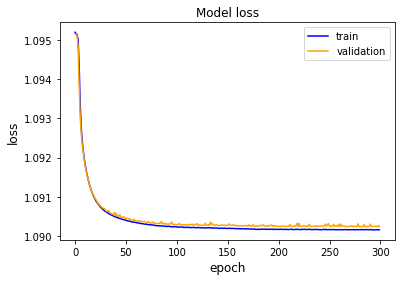

In [42]:


plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

In [45]:
predictions_on_test = model.predict(test_input_sequences_tensor2)

In [46]:
model.evaluate(test_input_sequences_tensor2,test_labels)

10104/10104 [==============================] - 0s 12us/step


[1.0902692891262111, 0.2964172604908947]

### Visualize inferred parameters (PWMs)

In [47]:
crp_weights = model.layers[4].get_weights()[0].copy()
rnap_weights = model.layers[5].get_weights()[0].copy()

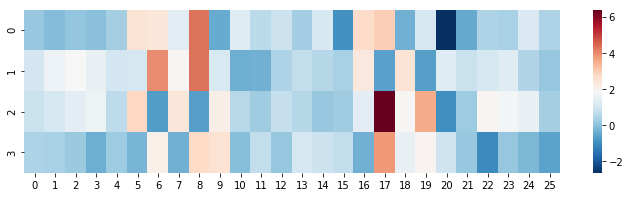

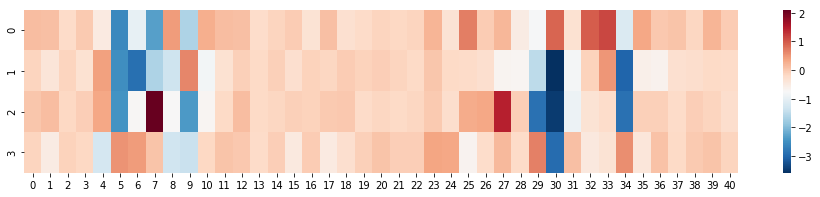

In [48]:
crp_weights = crp_weights.reshape(26,4)
rnap_weights = rnap_weights.reshape(41,4)


plt.figure(figsize=(12,3))
sns.heatmap(crp_weights.T,cmap='RdBu_r')
plt.show()
plt.figure(figsize=(16,3))
sns.heatmap(rnap_weights.T,cmap='RdBu_r')
#sns.heatmap(rnap_weights.T,cmap='RdBu_r')
plt.show()

### visualize parameters as sequences logos using logomaker

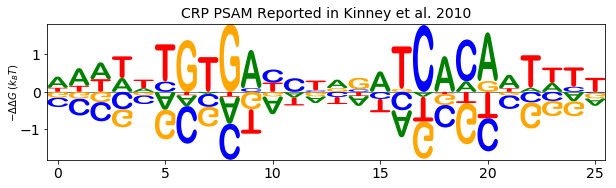

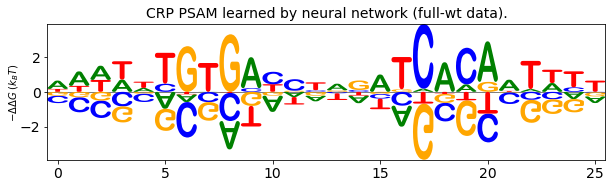

In [49]:
import logomaker
crp_logo_df = pd.DataFrame(crp_weights,columns=['A','C','G','T'])

crp_df.columns = ['A','C','G','T']
logomaker.Logo(-crp_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('CRP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
logomaker.Logo(-crp_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.title('CRP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)

plt.show()
#logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')

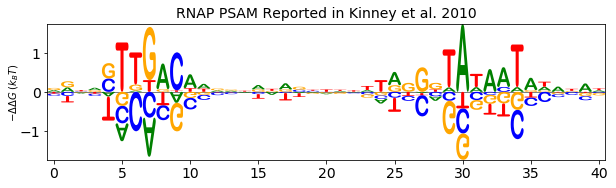

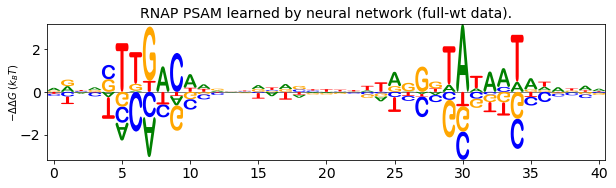

In [87]:
rnap_logo_df = pd.DataFrame(rnap_weights,columns=['A','C','G','T'])
rnap_df.columns = ['A','C','G','T']
logomaker.Logo(-rnap_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
plt.tick_params(labelsize=14)

### Inferred $\Delta G_I$

In [51]:
model.layers[6].get_weights()

[array([[-4.6800294]], dtype=float32)]

value in kcal/mol

In [2]:
-4.6800294*0.62

-2.901618228

Ensure that weights connecting $\Delta G$ nodes to microstate nodes stay fixed after training

In [54]:
model.layers[8].get_weights()

[array([[0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], dtype=float32)]

Weights of the $\tau$ layer, with the last two elements corresponding to $\tau_{max}$

In [55]:
model.layers[9].get_weights()

[array([[0.       ],
        [0.       ],
        [3.9697642],
        [3.904942 ]], dtype=float32)]